In [43]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y_damage_ambiguity, uncertainty_decomposition_damage_ambiguity
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [48]:
ξ_a = .01
# ξ_a = 1000.

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2, .3853*2])
# γ_2p = np.array([0, .0197*2*2, .3853*2])

y_step = .02
y_grid = np.arange(0., 4., y_step)

n_damage = len(γ_2p)
n_temp = 16
n_carb = 9

# Combine θ and γ_2p
θ_new = np.zeros((len(γ_2p), len(θ)))
γ_2p_new = np.zeros((len(γ_2p), len(θ)))
for i in range(len(γ_2p)):
    for j in range(len(θ)):
        θ_new[i, j] = θ[j]
        γ_2p_new[i, j] = γ_2p[i]
θ_new = θ_new.reshape(-1)
γ_2p_new = γ_2p_new.reshape(-1)
πc_o_new = np.ones_like(θ_new)/len(θ_new)

model_paras = (η, δ, θ_new, πc_o_new, σ_y, ξ_a, γ_1, γ_2, γ_2p_new, y_bar) 
model_res = ode_y_damage_ambiguity(y_grid, model_paras, v0=None, ϵ=1.,
                  tol=1e-8, max_iter=5_000, print_all=False)

Converged. Total iteration 1610: LHS Error: 9.954781887699937e-09; RHS Error 0.0018524755055898817


In [3]:
np.save('emission_damage_ambiguity', model_res['e_tilde'])

In [66]:
et, yt, _, _ = simulation(y_grid, model_res['e_tilde'],
                          np.zeros_like(y_grid),
                          np.zeros((3, len(y_grid))),
                          θ=np.mean(θ), y_start=np.mean(θ)*290, T=200)

In [68]:
yt_10 = yt[10]
yt_50 = yt[50]
yt_90 = yt[90]

yt_10_loc = find_nearest_value(y_grid, yt_10)
yt_50_loc = find_nearest_value(y_grid, yt_50)
yt_90_loc = find_nearest_value(y_grid, yt_90)

πc_10 = model_res['πc'][:, yt_10_loc].reshape((n_damage, n_temp, n_carb))
πc_50 = model_res['πc'][:, yt_50_loc].reshape((n_damage, n_temp, n_carb))
πc_90 = model_res['πc'][:, yt_90_loc].reshape((n_damage, n_temp, n_carb))

πc_10_damage = πc_10.sum(axis=(1, 2))
πc_50_damage = πc_50.sum(axis=(1, 2))
πc_90_damage = πc_90.sum(axis=(1, 2))

πc_10_temp_carb = πc_10.sum(axis=0).reshape(-1)
πc_50_temp_carb = πc_50.sum(axis=0).reshape(-1)
πc_90_temp_carb = πc_90.sum(axis=0).reshape(-1)

(0.8, 3.0)

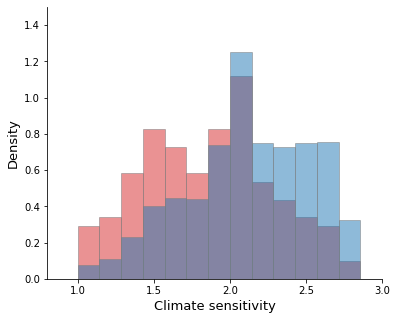

In [42]:
plt.figure(figsize=(6, 5))
bins = np.linspace(1., 3., 15)

plt.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
plt.hist(θ*1000, weights=πc_10_temp_carb, bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
plt.xlabel('Climate sensitivity', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.ylim(0, 1.5)
plt.xticks(np.arange(0,3+0.5, 0.5))
plt.xlim(.8, 3)

(0.8, 3.0)

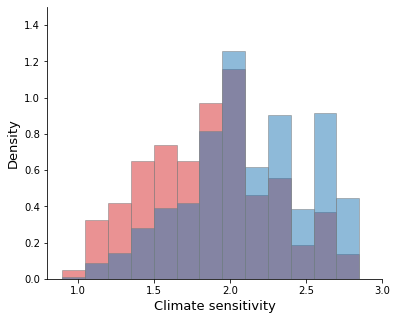

In [36]:
plt.figure(figsize=(6, 5))
bins = np.linspace(0., 3., 21)

plt.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
plt.hist(θ*1000, weights=πc_50_temp_carb, bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
plt.xlabel('Climate sensitivity', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.ylim(0, 1.5)
plt.xticks(np.arange(0,3+0.5, 0.5))
plt.xlim(.8, 3)

(0.8, 3.0)

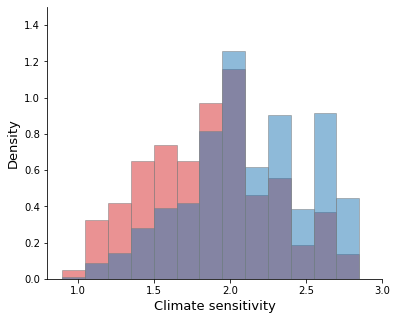

In [37]:
plt.figure(figsize=(6, 5))
bins = np.linspace(0., 3., 21)

plt.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
plt.hist(θ*1000, weights=πc_90_temp_carb, bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
plt.xlabel('Climate sensitivity', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.ylim(0, 1.5)
plt.xticks(np.arange(0,3+0.5, 0.5))
plt.xlim(.8, 3)

In [6]:
n_damage = len(γ_2p)
n_temp = 16
n_carb = 9

θ_reshape = θ.reshape(n_temp, n_carb)
θ_all = np.zeros((n_damage, n_temp, n_carb))
γ_2p_all = np.zeros((n_damage, n_temp, n_carb))

for i in range(n_damage):
    for j in range(n_temp):
        for n in range(n_carb):
            θ_all[i, j, n] = θ_reshape[j, n]
            γ_2p_all[i, j, n] = γ_2p[i]

θ_damage = θ_all.mean(axis=(1, 2))
θ_temp = θ_all.mean(axis=(0, 2))
θ_carb = θ_all.mean(axis=(0, 1))
γ_2p_damage = γ_2p_all.mean(axis=(1, 2))
γ_2p_temp = γ_2p_all.mean(axis=(0, 2))
γ_2p_carb = γ_2p_all.mean(axis=(0, 1))
πc_o_damage = np.ones_like(θ_damage)/len(θ_damage)
πc_o_temp = np.ones_like(θ_temp)/len(θ_temp)
πc_o_carb = np.ones_like(θ_carb)/len(θ_carb)

θ_damage_temp = θ_all.mean(axis=2).reshape(-1)
θ_damage_carb = θ_all.mean(axis=1).reshape(-1)
θ_temp_carb = θ_all.mean(axis=0).reshape(-1)
γ_2p_damage_temp = γ_2p_all.mean(axis=2).reshape(-1)
γ_2p_damage_carb = γ_2p_all.mean(axis=1).reshape(-1)
γ_2p_temp_carb = γ_2p_all.mean(axis=0).reshape(-1)
πc_o_damage_temp = np.ones_like(θ_damage_temp)/len(θ_damage_temp)
πc_o_damage_carb = np.ones_like(θ_damage_carb)/len(θ_damage_carb)
πc_o_temp_carb = np.ones_like(θ_temp_carb)/len(θ_temp_carb)

θ_baseline = θ_all.mean().reshape(-1)
γ_2p_baseline = γ_2p_all.mean().reshape(-1)
πc_o_baseline = np.ones_like(θ_baseline)/len(θ_baseline)

# Baseline
model_paras_baseline = (η, δ, θ_baseline, πc_o_baseline, σ_y, ξ_a, γ_1, γ_2, γ_2p_baseline, y_bar) 
model_baseline = uncertainty_decomposition_damage_ambiguity(y_grid, model_res['e_tilde'], model_paras_baseline, v0=None, ϵ=1.,
                  tol=1e-8, max_iter=5_000, print_all=False)

# Damage uncertainty
model_paras_damage = (η, δ, θ_damage, πc_o_damage, σ_y, ξ_a, γ_1, γ_2, γ_2p_damage, y_bar) 
model_damage = uncertainty_decomposition_damage_ambiguity(y_grid, model_res['e_tilde'], model_paras_damage, v0=None, ϵ=1.,
                  tol=1e-8, max_iter=5_000, print_all=False)

# Temperature uncertainty
model_paras_temp = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_a, γ_1, γ_2, γ_2p_temp, y_bar) 
model_temp = uncertainty_decomposition_damage_ambiguity(y_grid, model_res['e_tilde'], model_paras_temp, v0=None, ϵ=1.,
                  tol=1e-8, max_iter=5_000, print_all=False)

# Carbon uncertainty
model_paras_carb = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_a, γ_1, γ_2, γ_2p_carb, y_bar) 
model_carb = uncertainty_decomposition_damage_ambiguity(y_grid, model_res['e_tilde'], model_paras_carb, v0=None, ϵ=1.,
                  tol=1e-8, max_iter=5_000, print_all=False)

# Damage + Temperature uncertainty
model_paras_damage_temp = (η, δ, θ_damage_temp, πc_o_damage_temp, σ_y, ξ_a, γ_1, γ_2, γ_2p_damage_temp, y_bar) 
model_damage_temp = uncertainty_decomposition_damage_ambiguity(y_grid, model_res['e_tilde'], model_paras_damage_temp, v0=None, ϵ=1.,
                  tol=1e-8, max_iter=5_000, print_all=False)

# Damage + Carbon uncertainty
model_paras_damage_carb = (η, δ, θ_damage_carb, πc_o_damage_carb, σ_y, ξ_a, γ_1, γ_2, γ_2p_damage_carb, y_bar) 
model_damage_carb = uncertainty_decomposition_damage_ambiguity(y_grid, model_res['e_tilde'], model_paras_damage_carb, v0=None, ϵ=1.,
                  tol=1e-8, max_iter=5_000, print_all=False)

# Temperature + Carbon uncertainty
model_paras_temp_carb = (η, δ, θ_temp_carb, πc_o_temp_carb, σ_y, ξ_a, γ_1, γ_2, γ_2p_temp_carb, y_bar) 
model_temp_carb = uncertainty_decomposition_damage_ambiguity(y_grid, model_res['e_tilde'], model_paras_temp_carb, v0=None, ϵ=1.,
                  tol=1e-8, max_iter=5_000, print_all=False)

Converged. Total iteration 1598: LHS Error: 9.913168952380147e-09; RHS Error 0.0012292341416665666
Converged. Total iteration 1609: LHS Error: 9.929081556947494e-09; RHS Error 0.0015847062284322696
Converged. Total iteration 1598: LHS Error: 9.999931549486973e-09; RHS Error 0.0012626186355368645
Converged. Total iteration 1598: LHS Error: 9.942752399183519e-09; RHS Error 0.001241954209433408
Converged. Total iteration 1611: LHS Error: 9.951493851190207e-09; RHS Error 0.0016871514163743911
Converged. Total iteration 1610: LHS Error: 9.914081999795599e-09; RHS Error 0.0016236330752373521
Converged. Total iteration 1597: LHS Error: 9.948776025225925e-09; RHS Error 0.0013863318710715337


In [7]:
np.save('ME_baseline_damage_ambiguity', model_baseline['ME'])
np.save('ME_damage_damage_ambiguity', model_damage['ME'])
np.save('ME_temp_damage_ambiguity', model_temp['ME'])
np.save('ME_carb_damage_ambiguity', model_carb['ME'])
np.save('ME_damage_temp_damage_ambiguity', model_damage_temp['ME'])
np.save('ME_damage_carb_damage_ambiguity', model_damage_carb['ME'])
np.save('ME_temp_carb_damage_ambiguity', model_temp_carb['ME'])
np.save('ME_damage_ambiguity', η/model_res['e_tilde'])